# MNIST Tensor flow example
E. Krupczak - 18 Aug 2018

In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

#Import mnist data, which comes with tensor flow
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Components of MNIST
- mnist.train
- mnist.test
- mnist.validation
Each with images and labels

In [ ]:
mnist.train.labels

In [ ]:
mnist.train.labels.shape

In [ ]:
#This is a six
mnist.train.labels[600]

In [ ]:
#this is the first image
plt.matshow(mnist.train.images[600].reshape((28,-1)))

In [17]:
# Function to make weight and bias variables
# Number of weight variables: 784*number of nodes in next layer
# Number of bias (i.e. offset/intercept) variables: number of nodes in next layer

def weight_variable(shape):
    '''For matrix multiplication in fully-connected layers, weight variable shape is: input size * output size.'''
    #Normally distributed variables clamped between 0-1 with stddev as given
    initial = tf.truncated_normal(shape, stddev=0.1)
    #Return variable node
    return tf.Variable(initial)

def bias_variable(shape):
    ''' Bias variable shape is number of loads in next layer. '''
    #Slightly positive so we preserve more gradients for RELU non-linearity 
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [24]:
#input placeholder - 28x28 represented as a 784-length vector
input_ph = tf.placeholder(tf.float32, shape=[None,28*28], name='input_ph')
#output placeholder - a 10-length vector containing logits
output_ph = tf.placeholder(tf.float32, shape=[None,10], name='output_ph')
#learning rate 
learning_rate_ph = tf.placeholder(tf.float32, shape=[], name='learning_rate_ph')

#flow stores current node as we process through the layers
#Starts by pointing to placeholder node for input
flow = input_ph

#Make some layers
def make_layer(n):
    global flow
    #Use the shape of the previous layer to make the weight variable for the next
    w1 = weight_variable((int(flow.shape[-1]), n))
    b1 = bias_variable((n,))
    #right-multiply by the weight
    #flow points to computational node
    flow = tf.matmul(flow,w1)+b1
    
def make_nonlinearity():
    '''rectified linear'''
    global flow
    #updates computational node held by flow
    flow = tf.nn.relu(flow)
    
#Intersperse nonlinearity between the affine layers
make_layer(30)
make_nonlinearity()
make_layer(30)
make_nonlinearity()
make_layer(30)
make_nonlinearity()
make_layer(30)
make_nonlinearity()
make_layer(30)
make_nonlinearity()
make_layer(10)

network_output = flow

#Make loss computational node (returns loss as a number)
##Simplest loss function (squared error)
#loss = tf.reduce_mean((output_ph - network_output)**2)
##Cross-entropy loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    labels=output_ph, 
    logits=network_output, #unnormalized log probabilities of label classes
))

##Accuracy nodes
accuracy = tf.reduce_mean(tf.cast(
    tf.equal(tf.argmax(network_output,1), tf.argmax(output_ph,1)),
    tf.float32,
))

#Gradient descent with 'GradientDescentOptimizer'
#learning_rate = 0.1
#make training step computational node (has only side effects; returns none)
train_step = tf.train.GradientDescentOptimizer(learning_rate_ph).minimize(loss)

#Make a new session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [25]:
val_loss_list = []
in_sample_loss_list = []
accuracy_list = []

In [32]:
#Train the model
minibatchsize = 32
for i in range(40):
    #Compute loss and accuracy across validation set
    val_acc, val_loss = sess.run([accuracy,loss], feed_dict={
        input_ph: mnist.validation.images,
        output_ph: mnist.validation.labels,
    })
    #Compute loss in sample
    in_sample_loss = sess.run(loss, feed_dict={
        input_ph: mnist.train.images,
        output_ph: mnist.train.labels,
    })
    
    accuracy_list.append(val_acc)
    val_loss_list.append(val_loss)
    in_sample_loss_list.append(in_sample_loss)
    
    for j in range(100):
        minibatch_indices = random.sample(range(len(mnist.train.labels)),minibatchsize)
        sess.run(train_step, feed_dict={
            input_ph: [mnist.train.images[i] for i in minibatch_indices],
            output_ph: [mnist.train.labels[i] for i in minibatch_indices],
            learning_rate_ph:learning_rate,
        })
    print('Step:', len(val_loss_list)*100, ' Validation:', val_loss, 'In-sample:', in_sample_loss, 'Acc:', val_acc)

Step: 12100  Validation: 0.12036267 In-sample: 0.09355576 Acc: 0.9644
Step: 12200  Validation: 0.118699975 In-sample: 0.08245947 Acc: 0.9668
Step: 12300  Validation: 0.115114674 In-sample: 0.0782867 Acc: 0.9688
Step: 12400  Validation: 0.11309329 In-sample: 0.07643903 Acc: 0.9698
Step: 12500  Validation: 0.115030736 In-sample: 0.07881415 Acc: 0.966
Step: 12600  Validation: 0.11107295 In-sample: 0.07622841 Acc: 0.968
Step: 12700  Validation: 0.1122431 In-sample: 0.07851312 Acc: 0.9682
Step: 12800  Validation: 0.11002777 In-sample: 0.073440075 Acc: 0.9694
Step: 12900  Validation: 0.11272746 In-sample: 0.07392606 Acc: 0.9684
Step: 13000  Validation: 0.111306675 In-sample: 0.07327555 Acc: 0.9692
Step: 13100  Validation: 0.112780884 In-sample: 0.071959734 Acc: 0.9712
Step: 13200  Validation: 0.11312629 In-sample: 0.07126245 Acc: 0.97
Step: 13300  Validation: 0.110498525 In-sample: 0.071319014 Acc: 0.9706
Step: 13400  Validation: 0.110983066 In-sample: 0.06982645 Acc: 0.9698
Step: 13500  Val

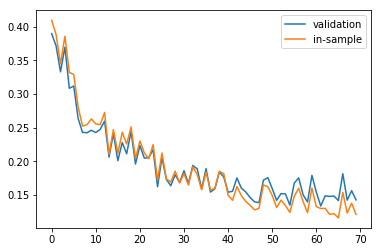

In [29]:
plt.plot(val_loss_list[10:])
plt.plot(in_sample_loss_list[10:])
plt.legend(['validation', 'in-sample'])

In [31]:
learning_rate = 0.02 #update learning rate

We can see that the validation loss starts to go up as the model overfits to the in-sample data set.

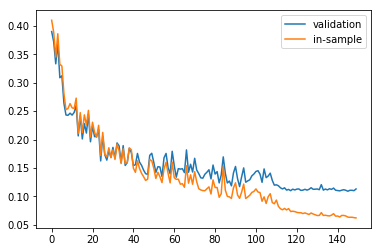

In [33]:
plt.plot(val_loss_list[10:])
plt.plot(in_sample_loss_list[10:])
plt.legend(['validation', 'in-sample'])

More smaller layers reduces the overfitting to in-sample. Reducing the learning rate decreases the noise, and increases the overfitting to the in-sample. (It would make the validation loss go down if our model hadn't converged.)

In [ ]:
#Run the model on the test images
model_output = sess.run(network_output, feed_dict={
    input_ph:mnist.test.images[0:10],
})

In [ ]:
model_output[0]

In [ ]:
def softmax(x):
    x = np.exp(x)
    return x/x.sum()

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.matshow([softmax(x) for x in model_output])
ax2.matshow(mnist.test.labels[0:10])

In [ ]:
plt.matshow(mnist.test.images[8].reshape((28,28)))